In [2]:
!pip install --quiet git+https://github.com/greentfrapp/lucent.git
!pip install --quiet transformers

     |████████████████████████████████| 225 kB 4.2 MB/s 
     |████████████████████████████████| 280 kB 63.1 MB/s 
     |████████████████████████████████| 280 kB 54.7 MB/s 
     |████████████████████████████████| 280 kB 62.0 MB/s 
     |████████████████████████████████| 280 kB 61.0 MB/s 
     |████████████████████████████████| 279 kB 61.9 MB/s 
     |████████████████████████████████| 279 kB 63.6 MB/s 
     |████████████████████████████████| 272 kB 53.1 MB/s 
     |████████████████████████████████| 272 kB 34.6 MB/s 
     |████████████████████████████████| 272 kB 48.9 MB/s 
     |████████████████████████████████| 270 kB 52.9 MB/s 
     |████████████████████████████████| 270 kB 17.3 MB/s 
     |████████████████████████████████| 270 kB 46.3 MB/s 
     |████████████████████████████████| 248 kB 64.1 MB/s 
     |████████████████████████████████| 247 kB 54.3 MB/s 
     |████████████████████████████████| 246 kB 63.5 MB/s 
     |████████████████████████████████| 247 kB 62.4 MB/s 
     |█████████

In [3]:
import torch

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo.util import get_model_layers
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer
from transformers import GPT2LMHeadModel
import matplotlib.pyplot as plt


import torchsummary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#set to relevant model location
binpath = "/content/drive/MyDrive/AM 205 - Group Project/tune/model_unique_rev_best/"
model = GPT2LMHeadModel.from_pretrained(binpath)
tok = AutoTokenizer.from_pretrained('gpt2')
tok.add_special_tokens({'pad_token': '<|endoftext|>'})

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

0

In [6]:
_ = model.to(device).eval()

In [7]:
get_model_layers(model)[:18]

['transformer',
 'transformer_wte',
 'transformer_wpe',
 'transformer_drop',
 'transformer_h',
 'transformer_h_0',
 'transformer_h_0_ln_1',
 'transformer_h_0_attn',
 'transformer_h_0_attn_c_attn',
 'transformer_h_0_attn_c_proj',
 'transformer_h_0_attn_attn_dropout',
 'transformer_h_0_attn_resid_dropout',
 'transformer_h_0_ln_2',
 'transformer_h_0_mlp',
 'transformer_h_0_mlp_c_fc',
 'transformer_h_0_mlp_c_proj',
 'transformer_h_0_mlp_dropout',
 'transformer_h_1']

In [8]:
tok.encode('the')

[1169]

In [9]:
gpt_transform = lambda x: x.to(torch.int)

numtokens = 50256

def gpt_inrandom(L=50):
  batch = 1
  ch = 1
  h = 1
  w = L
  out = torch.tensor(np.random.uniform(0,numtokens, size = (batch, ch, h, w))).to(device).requires_grad_(True)
  return [out], lambda: out

def gpt_in_the(L = 50):
  batch = 1
  ch = 1
  h = 1
  w = L
  out = torch.tensor(np.ones(shape = (batch, ch, h, w))).to(device).requires_grad_(True) * 1169
  return [out], lambda: out


params, input_f = gpt_in_the(5)
print(params)

print('\n' + tok.decode(gpt_transform(params[0][0][0][0])) + '\n' )
# gpt_inrandom(50)

hs = model(gpt_transform(params[0]), output_hidden_states=True).hidden_states

# print(len(hs))

for r in hs:
  print(r.size())

[tensor([[[[1169., 1169., 1169., 1169., 1169.]]]], device='cuda:0',
       dtype=torch.float64, grad_fn=<MulBackward0>)]

thethethethethe

torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 5, 768])
torch.Size([1, 1, 1, 5, 768])


In [10]:
wtembed = model.transformer.wte.weight

def obj(p, l, n):
  hidden = model(gpt_transform(p), output_hidden_states=True).hidden_states[l]
  # print(len(hidden.size()))
  # print(hidden.size())

  if len(hidden.size()) > 3:
    hidden = hidden[0][0]

  if len(hidden.size()) < 3:
    out = hidden[:,n].mean()
  else:
    out = hidden[0][:,n].mean()
  return out

In [11]:
obj(params[0], 12, 138)

tensor(0.4656, device='cuda:0', grad_fn=<MeanBackward0>)

In [356]:
#note: modify as necessary
save_loc = '/content/drive/MyDrive/AM 205 - Group Project/FeatureVis/'

In [358]:
iterations = 10
indices = 512

OLs = [11,]
ONs = np.ones(len(hs)-1)

for i in range(len(OLs)):
  optlayer = OLs[i]
  # optneuron = ONs[i]
  optneuron = int(np.random.uniform(768))

  print(f'Optimizing: Layer {optlayer}/12, neuron {optneuron+1}/768')

  # print(params)

  maxparams = params[0][0,0,0].clone()
  minparams = params[0][0,0,0].clone()


  # if len(maxparams.size()) > 3:
  #   maxparams = maxparams[0][0]
  #   minparams = minparams[0][0]

  # print(maxparams.size())

  alters = np.zeros(numtokens)
  negalters = np.zeros(numtokens)

  for t in tqdm(np.arange(numtokens)):
    # for t in tqdm(np.arange(numtokens), position=0):
      for w in range(len(maxparams)):
        pprime = maxparams.detach().clone()
        pprime[w] = t
        # print(pprime)
        loss = obj(pprime, optlayer, optneuron)
        if loss < alters[t]:
          alters[t] = loss
        elif loss > negalters[t]:
          negalters[t] = loss

  maxalters = np.argsort(alters)[:indices]
  minalters = np.argsort(negalters)[-indices:]

  maxalters = maxalters[alters[maxalters] < 0]
  minalters = minalters[negalters[minalters] > 0]

  print(len(maxalters), len(minalters))

  print(tok.decode(maxalters[:10]))
  print(tok.decode(minalters[:10]))
  # print(negalters[minalters])

  run_id = str(optlayer) + '_' + str(optneuron)
  np.save(save_loc + 'max_' + run_id, arr = maxalters)
  np.save(save_loc + 'min_' + run_id, arr = minalters)

Optimizing: Layer 11/12, neuron 78/768


100%|██████████| 50256/50256 [38:23<00:00, 21.82it/s]


512 512
Tr H TrsprHL Sp PSp h
 shortcuts escalated Everest Vehicles dirt damages ailments climb guards Flowers


In [104]:
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

In [13]:
tok.decode([10000,10001])

' pocket Inv'

In [357]:
optlayer = 11
optneuron = 692

#note: the below strings should point to the location specified above to save search outputs
run_id = str(optlayer) + '_' + str(optneuron)
maxalters = torch.as_tensor(np.load(save_loc + 'max_' + run_id + '.npy')).to(device)
minalters = torch.as_tensor(np.load(save_loc + 'min_' + run_id + '.npy')).to(device)

print(f'Loaded: Layer {optlayer}/12, neuron {optneuron+1}/768')

print(len(maxalters), len(minalters))
print(tok.decode(maxalters[:10]))
print(tok.decode(minalters[:10]))

Loaded: Layer 11/12, neuron 693/768
512 512
BSDArcadeBrewLinuxBurnStayplatform Fuck fuckedReloaded
 Ru Sut grim year vit coined Ray Teoly Cer


In [151]:
print(f"\\hline {optlayer}&{optneuron + 1}&", end = "")
for n in range(4):
  tm = maxalters[n].item()
  tn = minalters[n].item()
  print(f'[{tm}]: ``{tok.decode(tm)}";&[{tn}]: ``{tok.decode(tn)}"',end='\\\\&& ')

\hline 11&693&[21800]: ``BSD";&[11667]: `` Ru"\\&& [43763]: ``Arcade";&[45220]: `` Sut"\\&& [44029]: ``Brew";&[18288]: `` grim"\\&& [19314]: ``Linux";&[614]: `` year"\\&& 

In [152]:
tok.decode(43763)

'Arcade'

In [153]:
maxparams = params[0][0,0,0].clone()
minparams = params[0][0,0,0].clone()

In [154]:
best = obj(params[0][0,0,0], optlayer, optneuron)
for i in (range(iterations)):
  print(f'Pass {i+1}: {best}')
  oldbest = best
  for t in tqdm(maxalters):
  # for t in tqdm(np.arange(numtokens), position=0):
    for w in range(len(maxparams)):
      pprime = maxparams.detach().clone()
      pprime[w] = t
      loss = obj(pprime, optlayer, optneuron)
      if loss < best:
        best = loss
        maxparams = pprime.detach().clone()
  if best == oldbest:
    print(f'\nMax Activation: {tok.decode(maxparams.to(torch.int))}, Activation = {-best} ')
    break

Pass 1: 3.20208477973938


100%|██████████| 512/512 [00:23<00:00, 22.01it/s]


Pass 2: -13.528189659118652


100%|██████████| 512/512 [00:23<00:00, 22.09it/s]


Pass 3: -14.855822563171387


100%|██████████| 512/512 [00:23<00:00, 22.00it/s]


Max Activation: Arcade forgivingWebsite guiltyPlatform, Activation = 14.855822563171387 


In [155]:
print('\n' + tok.decode(gpt_transform(params[0][0][0][0])) + '\n' )
print(tok.decode(maxparams.to(torch.int)))
print(maxparams)


thethethethethe

Arcade forgivingWebsite guiltyPlatform
tensor([43763., 43486., 33420.,  6717., 37148.], device='cuda:0',
       dtype=torch.float64)


In [156]:
tok.encode('place spot')

[5372, 4136]

In [157]:
obj(torch.as_tensor(tok.encode(' Dimensions Horizons addressing Horizons address')).to(device), optlayer, optneuron)

tensor(5.9078, device='cuda:0', grad_fn=<MeanBackward0>)

In [158]:
print(obj(maxparams, optlayer, optneuron))
print(obj(torch.as_tensor([2, 2, 2, 0, 0,]).to(device), optlayer, optneuron))

tensor(-14.8558, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3423, device='cuda:0', grad_fn=<MeanBackward0>)


In [159]:
best = obj(params[0][0,0,0], optlayer, optneuron)
for i in (range(iterations)):
  print(f'Pass {i+1}: {best}')
  oldbest = best
  for t in tqdm(minalters):
  # for t in tqdm(np.arange(numtokens), position=0):
    for w in range(len(minparams)):
      pprime = minparams.detach().clone()
      pprime[w] = t
      loss = obj(pprime, optlayer, optneuron)
      if loss > best:
        best = loss
        minparams = pprime.detach().clone()
  if best == oldbest:
    print(f'\nMin Activation: {tok.decode(minparams.to(torch.int))}, Activation = {-best} ')
    break

Pass 1: 3.20208477973938


100%|██████████| 512/512 [00:23<00:00, 21.95it/s]


Pass 2: 16.1527042388916


100%|██████████| 512/512 [00:23<00:00, 21.81it/s]


Pass 3: 16.43670654296875


100%|██████████| 512/512 [00:23<00:00, 22.20it/s]


Min Activation:  NemDex Hod vit vit, Activation = -16.43670654296875 


In [160]:
print(torch.cat((minparams,maxparams)))

tensor([22547., 48875., 22816.,  9090.,  9090., 43763., 43486., 33420.,  6717.,
        37148.], device='cuda:0', dtype=torch.float64)


In [161]:
print(obj(maxparams, optlayer, optneuron))
print(obj(minparams, optlayer, optneuron))
print(obj(torch.cat((maxparams,minparams)), optlayer, optneuron))
print(obj(torch.cat((minparams,maxparams)), optlayer, optneuron))

tensor(-14.8558, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(16.4367, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6.5323, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.8838, device='cuda:0', grad_fn=<MeanBackward0>)


In [174]:
def compare(wordsA, wordsB):
  
  diffs = np.zeros([12,748])

  for l in range(12):
    for n in tqdm(range(748)):
      amean = 0
      for w in wordsA:
        t = tok.encode(w, return_tensors = 'pt').to(device)
        amean += obj(t, l, n).item()
      amean /= len(wordsA)

      bmean = 0
      for w in wordsB:
        t = tok.encode(w, return_tensors = 'pt').to(device)
        bmean += obj(t, l, n).item()
      bmean /= len(wordsB)
      diff = -(amean-bmean) #Negative obj => activation
      diffs[l,n] = diff
  
  return diffs


def ncompare(wordsA, wordsB, l, n):
  
  amean = 0
  for w in wordsA:
    t = tok.encode(w, return_tensors = 'pt').to(device)
    amean += obj(t, l, n).item()
  amean /= len(wordsA)

  bmean = 0
  for w in wordsB:
    t = tok.encode(w, return_tensors = 'pt').to(device)
    bmean += obj(t, l, n).item()
  bmean /= len(wordsB)
  diff = -(amean-bmean) #Negative obj => activation

  return amean, bmean, diff

In [191]:
def parsecompare(diffs, outs = 15):
  dmax = np.argsort(np.abs(diffs), axis = None)[-outs:]
  dlen = len(diffs[0])
  neurons = [[x//dlen, x%dlen, diffs[x//dlen][x%dlen]] for x in dmax]
  for l,n,d in neurons:
    print(f'Layer {l}, Neuron {n}: {np.round(d, 5)}')
  return neurons

In [316]:
wA = ['quick', 'true', 'good']
wB = ['quickly', 'truly', 'well']


d1 = compare(wA, wB)
n1 = parsecompare(d1)


100%|██████████| 748/748 [00:44<00:00, 16.94it/s]

Layer 10, Neuron 138: -236.58989
Layer 9, Neuron 138: -237.55456
Layer 8, Neuron 138: -238.34406
Layer 7, Neuron 138: -239.03957
Layer 6, Neuron 138: -239.69101
Layer 5, Neuron 138: -240.09257
Layer 3, Neuron 447: -762.21965
Layer 4, Neuron 447: -803.51921
Layer 5, Neuron 447: -846.02266
Layer 11, Neuron 447: -870.20691
Layer 6, Neuron 447: -872.03524
Layer 7, Neuron 447: -886.7207
Layer 10, Neuron 447: -894.14726
Layer 8, Neuron 447: -894.88668
Layer 9, Neuron 447: -896.53495


In [320]:
ddel = d1.copy()
ddel[:,138] = 0
ddel[:,447] = 0

n1 = parsecompare(ddel)

Layer 9, Neuron 373: -12.84391
Layer 9, Neuron 378: 13.16265
Layer 9, Neuron 481: 14.11415
Layer 8, Neuron 378: 14.86781
Layer 7, Neuron 378: 16.75904
Layer 6, Neuron 378: 18.78217
Layer 10, Neuron 373: -19.3925
Layer 5, Neuron 378: 20.30649
Layer 10, Neuron 481: 20.66901
Layer 4, Neuron 378: 20.74897
Layer 3, Neuron 378: 21.01327
Layer 2, Neuron 378: 21.89308
Layer 1, Neuron 378: 25.01204
Layer 11, Neuron 481: 49.69864
Layer 11, Neuron 373: -50.48909


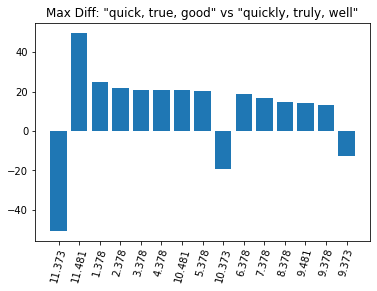

In [321]:

graphs = np.array(n1).T
# print(graphs)

nnames = np.flip(np.array([str(n[0]) + '.' + str(n[1]) for n in n1]))

plt.bar(nnames, np.flip(graphs[2]))

plt.title(f"Max Diff: \"{', '.join(wA)}\" vs \"{', '.join(wB)}\"")
plt.xticks(rotation = 75)
plt.show()